In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import abc
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from tqdm import tqdm_notebook as tqdm
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import random
import time
import pandas as pd
import seaborn as sns
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D,AveragePooling2D
import matplotlib.ticker as ticker

In [2]:
class AbstractLayer(tf.keras.layers.Layer):
    """Abstract Layer."""
    
    def __init__(self):
        """Inits the class."""
        super(AbstractLayer, self).__init__()
    
    @abc.abstractmethod
    def call(self, inputs):
        """Makes forward pass of the layer"""
        pass


class AbstractModel(tf.keras.Model):
    """Abstract model."""

    def __init__(self):
        """Inits the class."""
        super(AbstractModel, self).__init__()

    @abc.abstractmethod
    def call(self, inputs, training=False):
        """Makes forward pass of the network."""
        pass

    @abc.abstractmethod
    def fit(self, **kwargs):
        """Implements learning loop for the model.
        
        kwargs can contain optional parameters such as 
        num_epochs, batch_size, etc.
        """
        pass

    @abc.abstractmethod
    def predict(self, x):
        """Predicts outputs based on inputs (x)."""
        pass

In [3]:
cifar = tf.keras.datasets.cifar10

ORDERED_CLASS_NAMES=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

(x_train, y_train), (x_test, y_test) = cifar.load_data()

x_train, x_test = x_train / 255.0, x_test / 255.0
x_train[0].shape

(32, 32, 3)

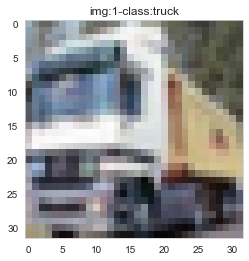

In [4]:
def plot_image(collection,number,labels=None,predicted=None):
    sns.set_style("whitegrid", {'axes.grid' : False})
    ax=plt.imshow(collection[number])
    title='img:'+str(number)
    if labels is not None:
        title+='-class:'+ORDERED_CLASS_NAMES[labels[number][0]]
    if predicted is not None:
        title+='-pred:'+ORDERED_CLASS_NAMES[predicted[number]]
    plt.title(title)
    plt.show()

plot_image(x_train,1,labels=y_train)

In [5]:
class ConvolutionalModel(AbstractModel):

    def __init__(self,pooling_type,kernel_size,first_dense_size):
        super(ConvolutionalModel, self).__init__()
        
        self.conv1 = Conv2D( kernel_size=kernel_size,strides=(1, 1),filters=64, activation='relu')
        self.pooling1=self.createPoolingLayer(pooling_type)    
        self.conv2 = Conv2D(kernel_size=kernel_size,strides=(1, 1),filters=64, activation='relu')
        self.pooling2=self.createPoolingLayer(pooling_type)  
        self.flatten = Flatten()
        
        self.d1 = Dense(first_dense_size, activation='relu')
        self.d2 = Dense(384, activation='relu')
        self.d3 = Dense(192, activation='softmax')
         
        #STATISTICS
        self.train_learning_accuracy=[]
        self.test_learning_accuracy=[]
        self.train_learning_losses=[]
        self.test_learning_losses=[]
    
    def createPoolingLayer(self,pooling_type):
        if pooling_type == 'max':
            return MaxPooling2D(pool_size=(3,3),strides=(2, 2))  
        else:
            return AveragePooling2D(pool_size=(3,3),strides=(2, 2)) 
        

             
    def call(self, inputs, training=False):
        """Makes forward pass of the network."""
        x = self.conv1(inputs)
        x = self.pooling1(x)
        x = self.conv2(x)
        x = self.pooling2(x)
        x = self.flatten(x)
        x = self.d1(x)
        x = self.d1(x)
        return self.d3(x)
    

    def predict(self, x):
        res=self.call(x)
        return np.argmax(res,axis=-1)
        
    
    @tf.function
    def train_step(self,images, labels,optimizer,loss_function, train_loss_metric,train_accuracy):
        with tf.GradientTape() as tape:
            predictions = self(images)
            loss = loss_function(labels, predictions)
        gradients = tape.gradient(loss, self.trainable_variables)
        optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        train_loss_metric(loss)
        train_accuracy(labels, predictions)
        
    @tf.function
    def test_step(self,images, labels,loss_function,test_loss_metric,test_accuracy):
        predictions = self(images)
        t_loss = loss_function(labels, predictions)
        test_loss_metric(t_loss)
        test_accuracy(labels, predictions)

    def fit(self,train_xs,train_ys,test_xs,test_ys,loss_function=tf.keras.losses.SparseCategoricalCrossentropy,
            epochs=10,optimizer=tf.keras.optimizers.Adam,learning_rate=0.001,batch_size=100,verbose=False):
        
        train_ds = tf.data.Dataset.from_tensor_slices((train_xs,train_ys)).shuffle(5000).batch(batch_size)
        
        test_ds = tf.data.Dataset.from_tensor_slices((test_xs, test_ys)).batch(batch_size)
        
        optimizer = optimizer(learning_rate=learning_rate)
        
        loss_function=loss_function()
        
        self.train_learning_accuracy=[]
        self.test_learning_accuracy=[]
        self.train_learning_losses=[]
        self.test_learning_losses=[]

        train_loss_metric = tf.keras.metrics.Mean(name='train_loss_metric')
        train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

        test_loss_metric = tf.keras.metrics.Mean(name='test_loss_metric')
        test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')
        
        for epoch in tqdm(range(epochs)):
            for batch_images,batch_labels in train_ds:
                start_point = time.time()
                self.train_step(batch_images, batch_labels,optimizer,loss_function,train_loss_metric,train_accuracy)

            for test_images, test_labels in test_ds:
                self.test_step(test_images, test_labels,loss_function,test_loss_metric,test_accuracy)
                
            if verbose:
                template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
                print(template.format(epoch+1,
                            train_loss_metric.result(),
                            train_accuracy.result()*100,
                            test_loss_metric.result(),
                            test_accuracy.result()*100))
                
            self.train_learning_accuracy.append(train_accuracy.result().numpy()*100)
            self.test_learning_accuracy.append(test_accuracy.result().numpy()*100)
            self.train_learning_losses.append(train_loss_metric.result().numpy())
            self.test_learning_losses.append(test_loss_metric.result().numpy())

            # Reset the metrics for the next epoch
            train_loss_metric.reset_states()
            train_accuracy.reset_states()
            test_loss_metric.reset_states()
            test_accuracy.reset_states()
    

In [101]:
model_i=ConvolutionalModel(pooling_type='max',kernel_size=(2,2),first_dense_size=2304)
model_i.fit(x_train,y_train,x_test,y_test,verbose=True,learning_rate=0.0008)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1, Loss: 1.5243158340454102, Accuracy: 45.0, Test Loss: 1.2407251596450806, Test Accuracy: 56.040000915527344
Epoch 2, Loss: 1.04908287525177, Accuracy: 62.981998443603516, Test Loss: 0.9550654888153076, Test Accuracy: 66.65999603271484
Epoch 3, Loss: 0.8657556772232056, Accuracy: 69.73600006103516, Test Loss: 0.8917029500007629, Test Accuracy: 68.23999786376953
Epoch 4, Loss: 0.720028817653656, Accuracy: 74.76799774169922, Test Loss: 0.7993171811103821, Test Accuracy: 72.39999389648438
Epoch 5, L

In [139]:
def run_tests(file_name):
    EPOCHS=15
    LEARNING_RATE=[0.0009,0.0005,0.0001]
    BATCH_SIZE=[100,200]
    KERNEL_SIZES=[(2,2,2304),(3,3,1600),(5,5,1024)]
    POOLINGS=['max','average']

    df = pd.DataFrame(columns=['EPOCHS','LEARNING_RATE', 'BATCH_SIZE','KERNEL','POOLING','ACC_TRAIN', 'ACC_TEST','ERROR_TRAIN','ERROR_TEST'])
    df.to_csv('./csv/' + file_name + '.csv',index=False)
    
    for lr in LEARNING_RATE:
        for batch_size in BATCH_SIZE:
            for size1,size2,dense_size in KERNEL_SIZES:
                for pool in POOLINGS:
                    
                    t_model=ConvolutionalModel(pooling_type=pool,kernel_size=size1,first_dense_size=dense_size)
                    t_model.fit(x_train,y_train,x_test,y_test,verbose=False,learning_rate=lr,batch_size=batch_size,epochs=EPOCHS)
                    
                    for epoch in range(EPOCHS):
                        acc_train=t_model.train_learning_accuracy[epoch]
                        acc_test=t_model.test_learning_accuracy[epoch]

                        error_train=t_model.train_learning_losses[epoch]
                        error_test=t_model.test_learning_losses[epoch]
                        
                        subdf=pd.DataFrame(zip([epoch+1],[lr],[batch_size],[size1],[pool],[acc_train],[acc_test],[error_train],[error_test]),
                                           columns=['EPOCHS','LEARNING_RATE', 'BATCH_SIZE','KERNEL','POOLING','ACC_TRAIN', 'ACC_TEST','ERROR_TRAIN','ERROR_TEST'])
       
                        subdf.to_csv('./csv/' + file_name + '.csv', mode='a', header=False, index=False)
        
        

In [140]:
run_tests('research')


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.





If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.





If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.





If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.





If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.





If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.





If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.





If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.





If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.





If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.





If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.





If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.





If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.





If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.





If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.





If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.





If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.





If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.





If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.





If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.





If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.





If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.





If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.





If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.





If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.





If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.





If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.





If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.





If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.





If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.





If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.





If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.





If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.





If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.





If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.





If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




### Wyniki

#### Wszystkie

In [167]:
results=pd.read_csv('csv/research.csv')
results.sort_values(by=['ACC_TEST'], ascending=False)

,EPOCHS,LEARNING_RATE,BATCH_SIZE,KERNEL,POOLING,ACC_TRAIN,ACC_TEST,ERROR_TRAIN,ERROR_TEST
129,10,0.0009,200,3,max,87.739998,75.019997,0.353354,0.870113
313,14,0.0005,200,3,max,91.101998,74.940002,0.261526,0.919568
188,9,0.0005,100,2,max,90.256000,74.890000,0.280698,0.862547
133,14,0.0009,200,3,max,95.779997,74.760002,0.123064,1.213873
193,14,0.0005,100,2,max,97.421998,74.699998,0.074358,1.291470
...,...,...,...,...,...,...,...,...,...
435,1,0.0001,100,5,average,27.248001,37.400001,2.067515,1.740847
465,1,0.0001,200,2,average,25.770000,36.809999,2.133406,1.791958
510,1,0.0001,200,5,max,23.528001,34.740001,2.207788,1.795659
525,1,0.0001,200,5,average,23.695999,34.000000,2.261268,1.825124


#### Top ten

In [168]:
results=pd.read_csv('csv/research.csv')
results=results[results['ACC_TEST']>70]
results.sort_values(by=['ACC_TEST'], ascending=False)[:10]

,EPOCHS,LEARNING_RATE,BATCH_SIZE,KERNEL,POOLING,ACC_TRAIN,ACC_TEST,ERROR_TRAIN,ERROR_TEST
129,10,0.0009,200,3,max,87.739998,75.019997,0.353354,0.870113
313,14,0.0005,200,3,max,91.101998,74.940002,0.261526,0.919568
188,9,0.0005,100,2,max,90.256000,74.890000,0.280698,0.862547
133,14,0.0009,200,3,max,95.779997,74.760002,0.123064,1.213873
193,14,0.0005,100,2,max,97.421998,74.699998,0.074358,1.291470
5,6,0.0009,100,2,max,84.399998,74.690002,0.446215,0.804349
194,15,0.0005,100,2,max,97.605997,74.680001,0.071616,1.372198
190,11,0.0005,100,2,max,95.196003,74.659997,0.142617,1.121153
283,14,0.0005,200,2,max,94.000000,74.559999,0.181062,0.986679
221,12,0.0005,100,3,max,94.503999,74.540001,0.161976,1.065999


### Wpływ hiperparamterów uczenia

In [7]:
all_results=pd.read_csv('csv/research.csv')

#### Wpływ współczynnik uczenia

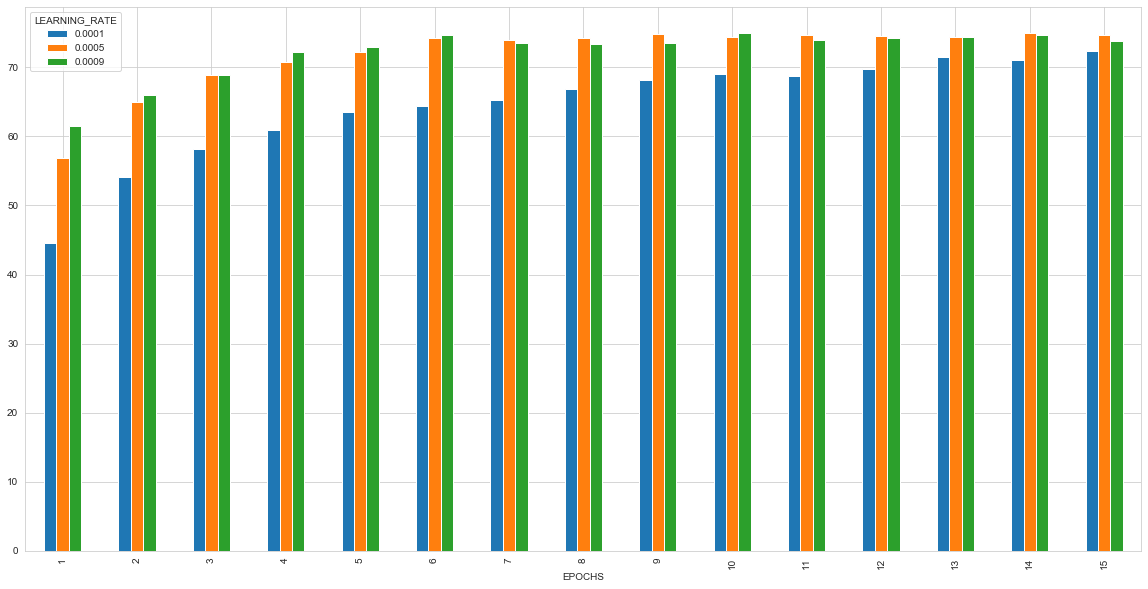

In [185]:
sns.set_style("whitegrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(20,10))
all_results.groupby(['EPOCHS','LEARNING_RATE',]).max()['ACC_TEST'].unstack().plot.bar(ax=ax)

Przy mniejszej liczbie epok najlepsze rezultaty osiągnął współczynnik 0.0009 (najgorsze 0.0001). Przy większej liczbie epok konkurencyjny był również współczynnik 0.0005. Od 11 epoki wzwyż, współczynnik 0.0005 dawał lepsze rezultaty niż 0.0009. 

#### Wpływ rozmiaru batcha

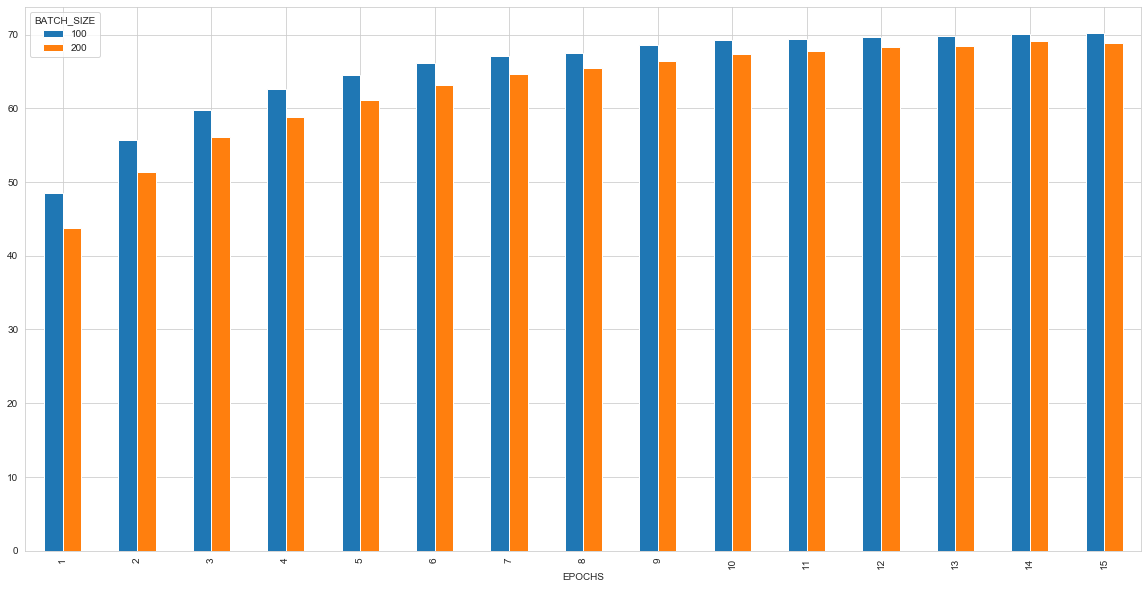

In [8]:
sns.set_style("whitegrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(20,10))
all_results.groupby(['EPOCHS','BATCH_SIZE',]).mean()['ACC_TEST'].unstack().plot.bar(ax=ax)

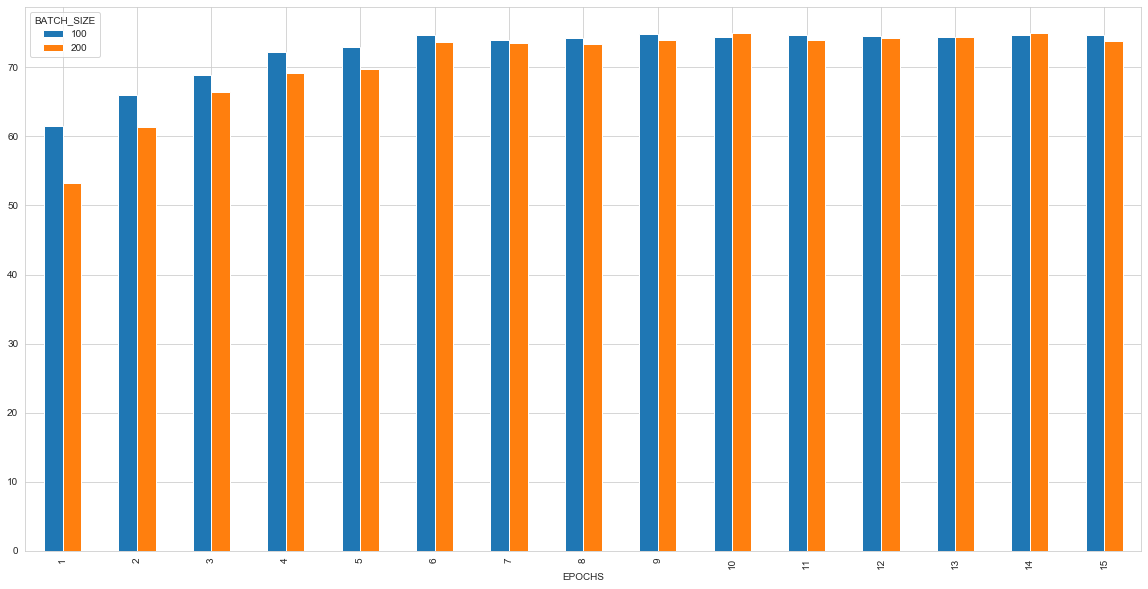

In [9]:
sns.set_style("whitegrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(20,10))
all_results.groupby(['EPOCHS','BATCH_SIZE',]).max()['ACC_TEST'].unstack().plot.bar(ax=ax)

Przy uczeniu z mniejszą liczbą epok, mniejszy rozmiar batcha daje dużą przewagę. Przewaga ta zaciera się dla większej ilości epok. Globalnie najlepsze rezultaty otrzymano dla większego batcha.


### Wpływ parametrów sieci konwolucyjnej 

##### Wartości maksymalne

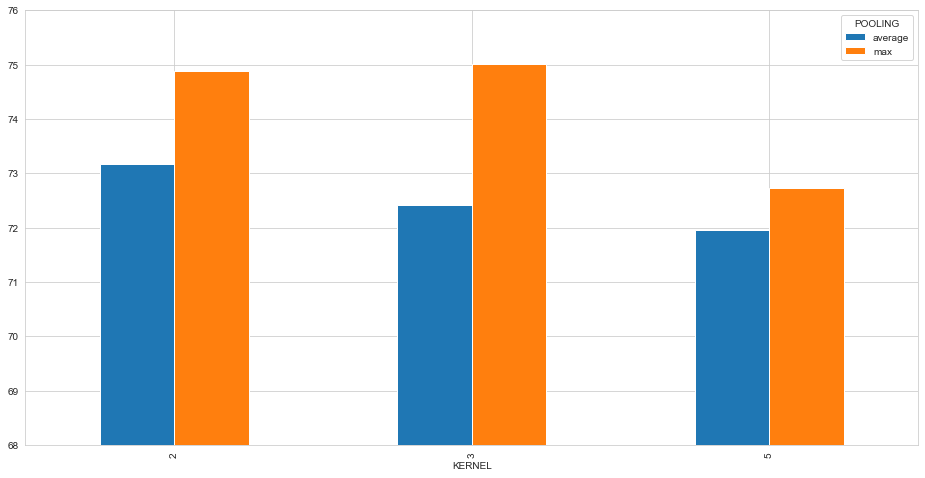

In [164]:
sns.set_style("whitegrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(16,8))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.set_ylim(bottom=68,top=76)
results.groupby(['KERNEL','POOLING']).max()['ACC_TEST'].unstack().plot.bar(ax=ax)

Najlepsze wyniki uzyskano przy rozmiarze okna konwolucji równego 3. Małe rozmiary kernela: (2,2) , (3,3) radziły sobie lepiej niż większy (5,5). Average pooling daje gorsze rezultaty niż max pooling.


##### Wartości średnie

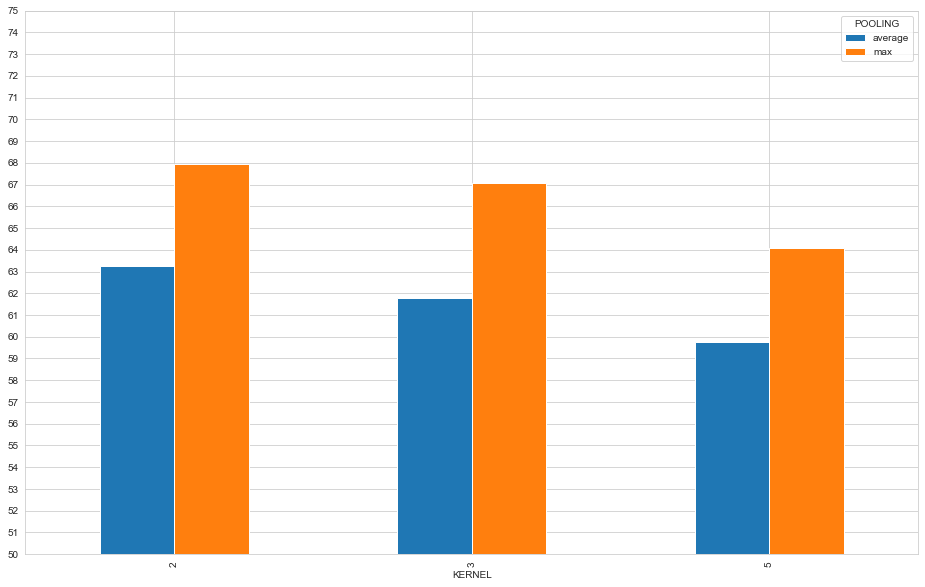

In [159]:
sns.set_style("whitegrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(16,10))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.set_ylim(bottom=50,top=75)
results.groupby(['KERNEL','POOLING']).mean()['ACC_TEST'].unstack().plot.bar(ax=ax)

Max pooling daje globalnioe lepsze efekty niż averrage pooling. Średnio im większy kernel, tym gorsze  rezutaty.


### Najlepszy model (kernel=3,pooling=max,Adam,lr=0.0009,epochs=10,batch=200)

### Wyniki dla konkurencyjnego modelu (kernel=2,pooling=max,epochs 10,batch=100)

In [14]:
model_best=ConvolutionalModel(pooling_type='max',kernel_size=(2,2),first_dense_size=2304)
model_best.fit(x_train,y_train,x_test,y_test,verbose=True,learning_rate=0.0005,epochs=10,batch_size=100)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1, Loss: 1.5840399265289307, Accuracy: 43.10199737548828, Test Loss: 1.2082269191741943, Test Accuracy: 57.30000305175781
Epoch 2, Loss: 1.1167104244232178, Accuracy: 60.53799819946289, Test Loss: 1.034337043762207, Test Accuracy: 63.12999725341797
Epoch 3, Loss: 0.9329452514648438, Accuracy: 67.37200164794922, Test Loss: 0.9099755883216858, Test Accuracy: 67.54000091552734
Epoch 4, Loss: 0.8027011156082153, Accuracy: 71.80999755859375, Test Loss: 0.849407434463501, Test Accuracy: 70.4800033569336

In [15]:
def visualize_learning(model):
    sns.set()
    fig, (error_subplot, accuracy_subplot) = plt.subplots(1, 2,figsize=(15,5))
    epochs=[i+1 for i in range(len(model.train_learning_accuracy))]
    
    train_errors,test_errors=model.train_learning_losses,model.test_learning_losses
    train_accuracy,test_accuracy=model.train_learning_accuracy,model.test_learning_accuracy

    accuracy_subplot.plot(epochs,train_accuracy,linestyle='--', marker='o', color='green', label='Traing set accuracy')
    accuracy_subplot.plot(epochs,test_accuracy,linestyle='--', marker='o', color='blue', label='Test set accuracy')
    accuracy_subplot.set_title("Model accuracy change per epoch")
    accuracy_subplot.set_xlabel('Epochs')
    accuracy_subplot.set_ylabel('Loss')
    accuracy_subplot.legend(loc="upper left")
    
    error_subplot.plot(epochs,train_errors,linestyle='--', marker='o', color='red',label='Traing set loss')
    error_subplot.plot(epochs,test_errors,linestyle='--', marker='o', color='orange',label='Test set loss')
    error_subplot.set_title("Model loss change per epoch")
    error_subplot.set_xlabel('Epochs')
    error_subplot.set_ylabel('Loss')
    error_subplot.legend(loc="upper right")

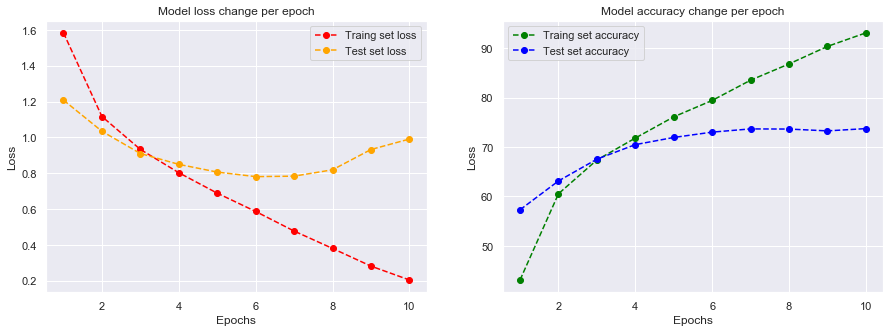

In [16]:
visualize_learning(model_best)

In [17]:
predicted_labels=model_best.predict(x_test)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



[[759  22  31  35  26   5   6  16  53  47]
 [ 12 834   2  21   3   5   7   8  30  78]
 [ 72   9 545 101  72  66  49  60  14  12]
 [ 20   7  21 646  58 113  39  57  16  23]
 [ 13   2  46  70 718  36  33  69   9   4]
 [ 11   5  27 236  28 593  19  67   5   9]
 [  8   9  30 107  27  19 772  18   8   2]
 [  8   0   6  37  39  40   1 851   8  10]
 [ 54  31   8  21   5   9   5  13 823  31]
 [ 19  73   3  14   2   9   2  22  25 831]]


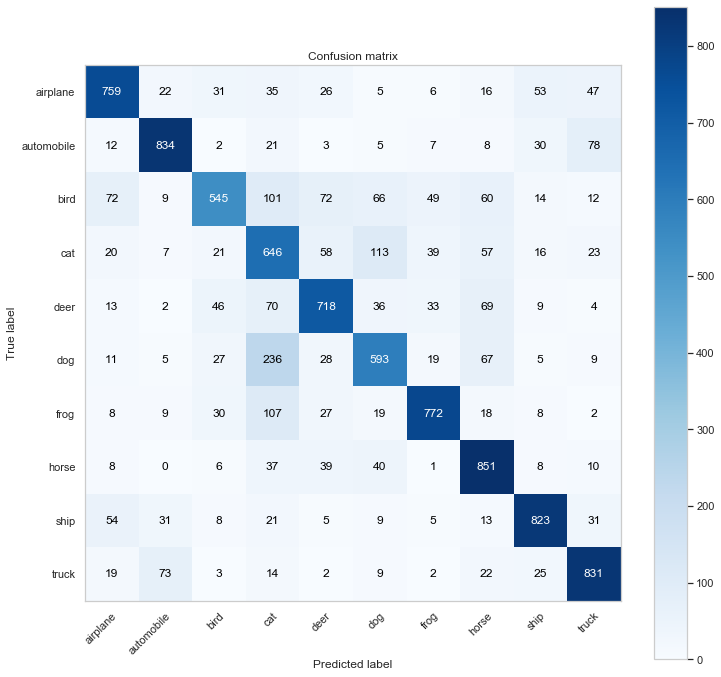

In [18]:
def visualize_confusion_matrix(y_true, y_pred, classes,
                          title=None):

    sns.set_style("whitegrid", {'axes.grid' : False})
    cm = confusion_matrix(y_true, y_pred)
    print(cm)

    fig, ax = plt.subplots(figsize=(12,12))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    
    #setting labels
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),

           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # label rotation
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # text annotations
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    #bug workarond
    ax.set_ylim(len(classes)-0.5, -0.5)
    return ax

visualize_confusion_matrix(y_test, predicted_labels, classes=ORDERED_CLASS_NAMES,
                      title='Confusion matrix')

Najlepiej rozpoznawane były konie, samochody, ciężarówki i statki. Postęp w porówaniu z siecią NLP jest bardzo widoczny po macierzy konfuzji. Nagorzej rozpoznawane były ptaki, psy i koty. Widać,że obiekty biologiczne były ze sobą na wzajem mylone.

In [19]:
def get_wrong_indices_list_per_class(class_id,labels,predicted):
    indexes=[]
    list_predicted=predicted.tolist()
    list_real=labels.transpose()[0].tolist()
    for i in range(len(list_real)):
        if list_real[i]!=list_predicted[i] and list_real[i]==class_id:
            indexes.append(i)
    return indexes

def get_class_indices(class_id,labels):
    result = np.where(labels == class_id)
    return result[0]

def visualize_n_images_horizontally(n, collection, indices_list, labels=None, predicted=None):
    sns.set_style("whitegrid", {'axes.grid' : False})
    fig, subplots = plt.subplots(1, n, figsize=(16,5))
    for subplot in subplots:
        number=random.choice(indices_list)
        ax=subplot.imshow(np.reshape(collection[number],(32, 32, 3)))
        title=str(number)
        if labels is not None:
            title+='-cl:'+ORDERED_CLASS_NAMES[labels[number][0]]
        if predicted is not None:
            title+='-p:'+ORDERED_CLASS_NAMES[predicted[number]]
        subplot.set_title(title)
    plt.show()

def visualize_n_represenative_class_examples(n,collection,labels):
    for i in range(len(ORDERED_CLASS_NAMES)):
        print(ORDERED_CLASS_NAMES[i])
        class_indices=get_class_indices(i,labels)
        visualize_n_images_horizontally(n,collection,class_indices,labels=labels)

def visualize_n_differing_for_each_class(n,collection,labels,predicted):
    for i in range(len(ORDERED_CLASS_NAMES)):
        print(ORDERED_CLASS_NAMES[i])
        mispredicted_indices=get_wrong_indices_list_per_class(i,labels,predicted)
        visualize_n_images_horizontally(n,collection,mispredicted_indices,predicted=predicted)
        


### Źródła błędów

W przypadku obiektów technicznych błedy wynikały z ekspozycji(podłużne samochody mylone z ciężarówkami) lub otecznia. 
W przypadku obiektów biologicznych błędy mogły wynikać z otoczneia, ale też bardziej złożonych cech np. bardziej okragły kształ głowy kota niż psa, ogon, uszy itp.

airplane


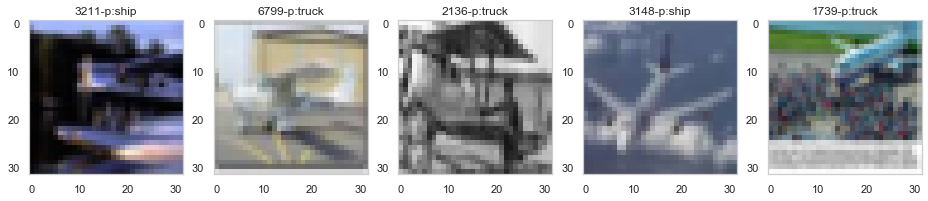

automobile


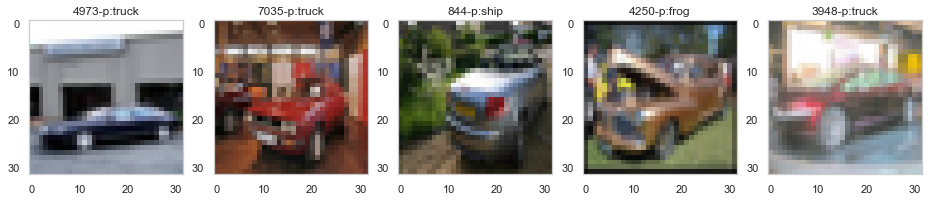

bird


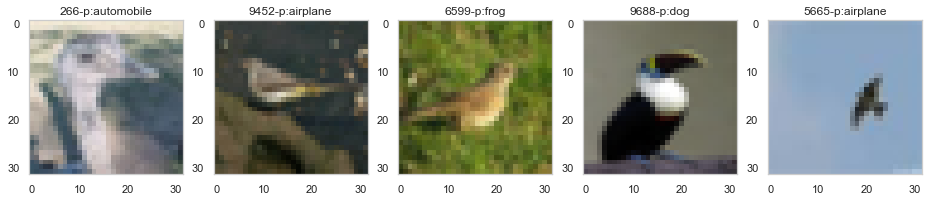

cat


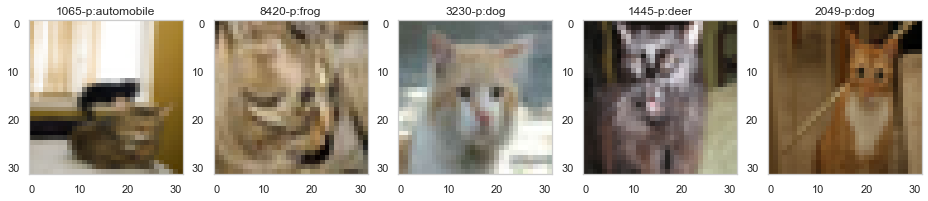

deer


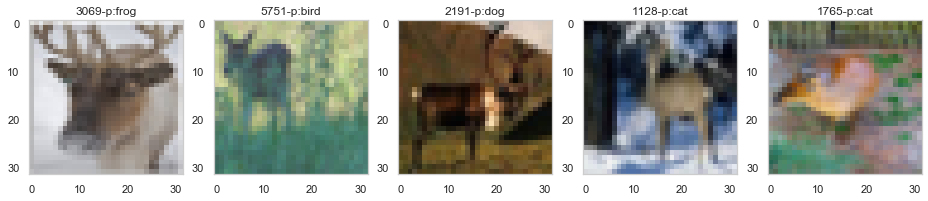

dog


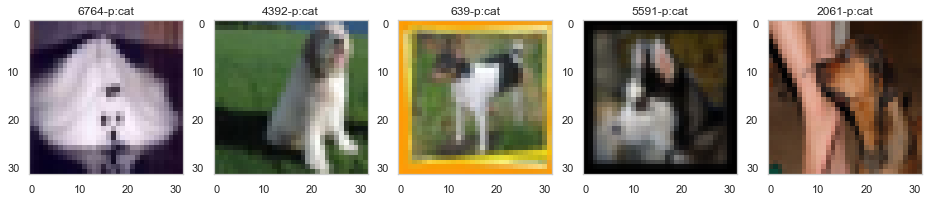

frog


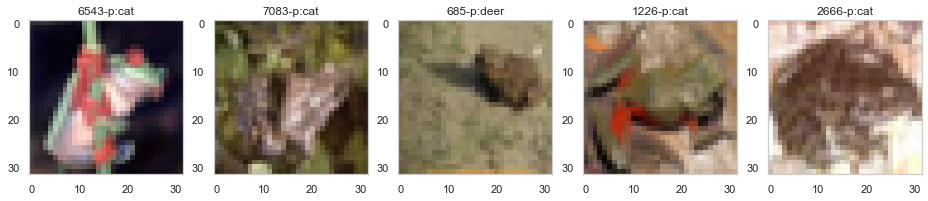

horse


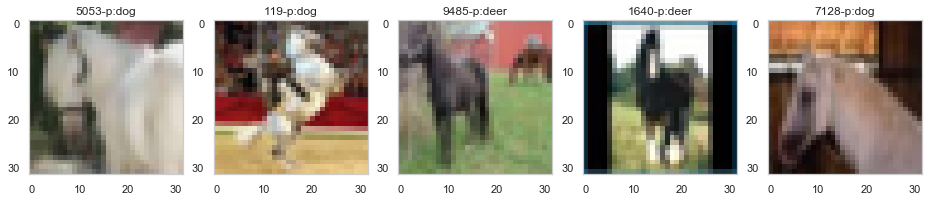

ship


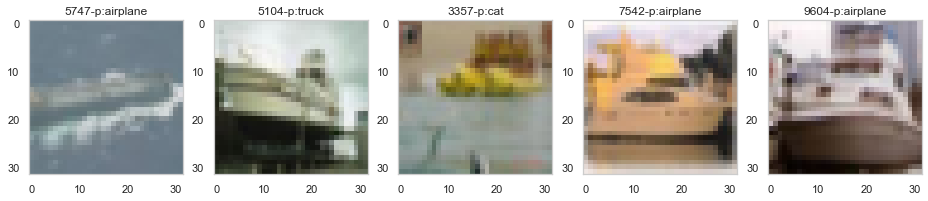

truck


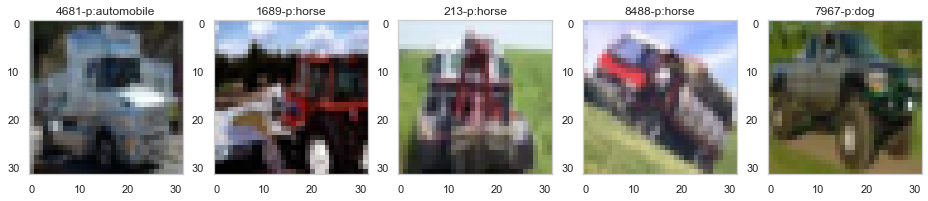

In [20]:
visualize_n_differing_for_each_class(5,x_test,y_test,predicted_labels)